In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data=kgs.load_all_train_data()

In [1]:
1350*32*282*1000*4/1e9

48.7296

In [3]:
#Load input to identify jitter shapes

importlib.reload(ariel_numerics)
loaders = ariel_load.default_loaders()
for ii in range(2):
    loaders[ii].apply_pixel_corrections.mask_hot= False
res = []
#plt.figure()
for d in tqdm(train_data[:25]):
    d = copy.deepcopy(d)
    
    d.load_to_step(3, loaders)
    
    data = d.transits[0].data[1].data
    
    residuals = ariel_numerics.remove_trend_cp(data)[10:-10,...]
    
    ariel_load.inpaint_vectorized(data)
    assert not cp.any(cp.isnan(data))

    x=cp.mean(data,(0,1))
    if d.planet_id == train_data[0].planet_id:
        base_scaling = x
    residuals = residuals/x*base_scaling
    
    #plt.plot(x.get())
    
    d.load_to_step(0, ariel_load.default_loaders())
    res.append(residuals)

res = cp.concatenate(res)
print('GB used: ', 8*np.prod(res.shape)/1e9)
kgs.dill_save(kgs.temp_dir + 'prep_AIRS_jitter_data.pickle', (res,base_scaling))

res,base_scaling = kgs.dill_load(kgs.temp_dir + 'prep_AIRS_jitter_data.pickle')

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.51s/it]


GB used:  1.994304


  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

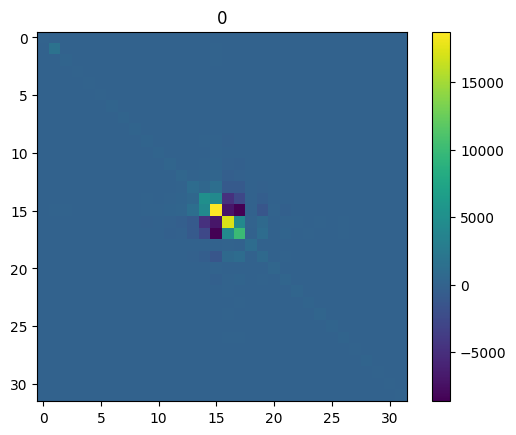

 33%|████████████████████████████▎                                                        | 1/3 [00:08<00:16,  8.20s/it]

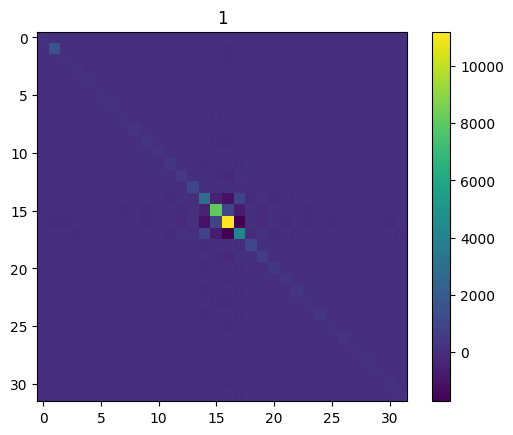

 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:19<00:09,  9.74s/it]

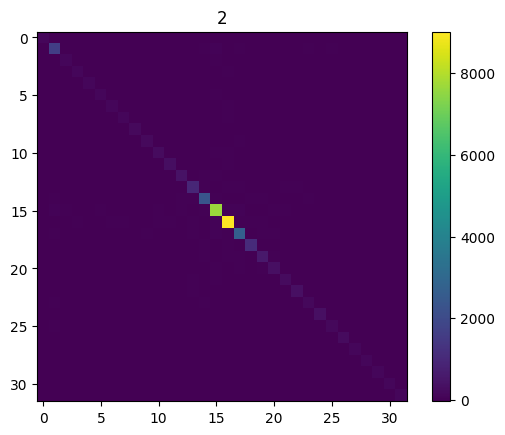

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:47<00:00, 15.71s/it]


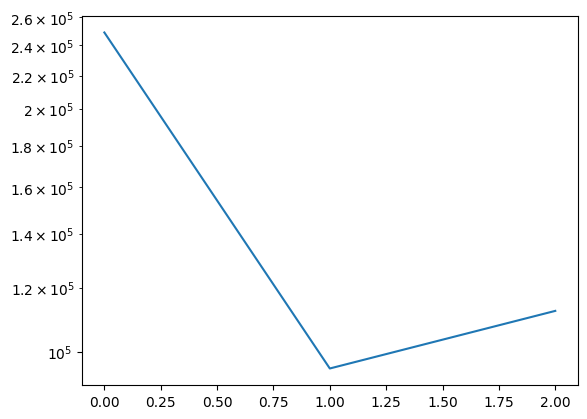

In [4]:
kgs.clear_gpu()
S = [];components = []; weights = []
dat = copy.deepcopy(res.reshape(res.shape[0],-1))
for ii in tqdm(range(3)):
    resF = dat[:,::282]
    cov = (resF.T@resF)/resF.shape[0]
    plt.figure()
    plt.imshow(cov.get())
    plt.colorbar()
    plt.title(ii)
    plt.pause(0.001)
    this_weights, this_components, this_S = ariel_numerics.nan_pca(dat, 1, tol=1e-1, verbose=False)
    dat -= this_weights * this_components
    S.append(this_S.get())
    components.append(this_components)
    weights.append(this_weights)
    resF = dat
    cov = (resF.T@resF)/resF.shape[0]
plt.figure()
plt.semilogy(S)

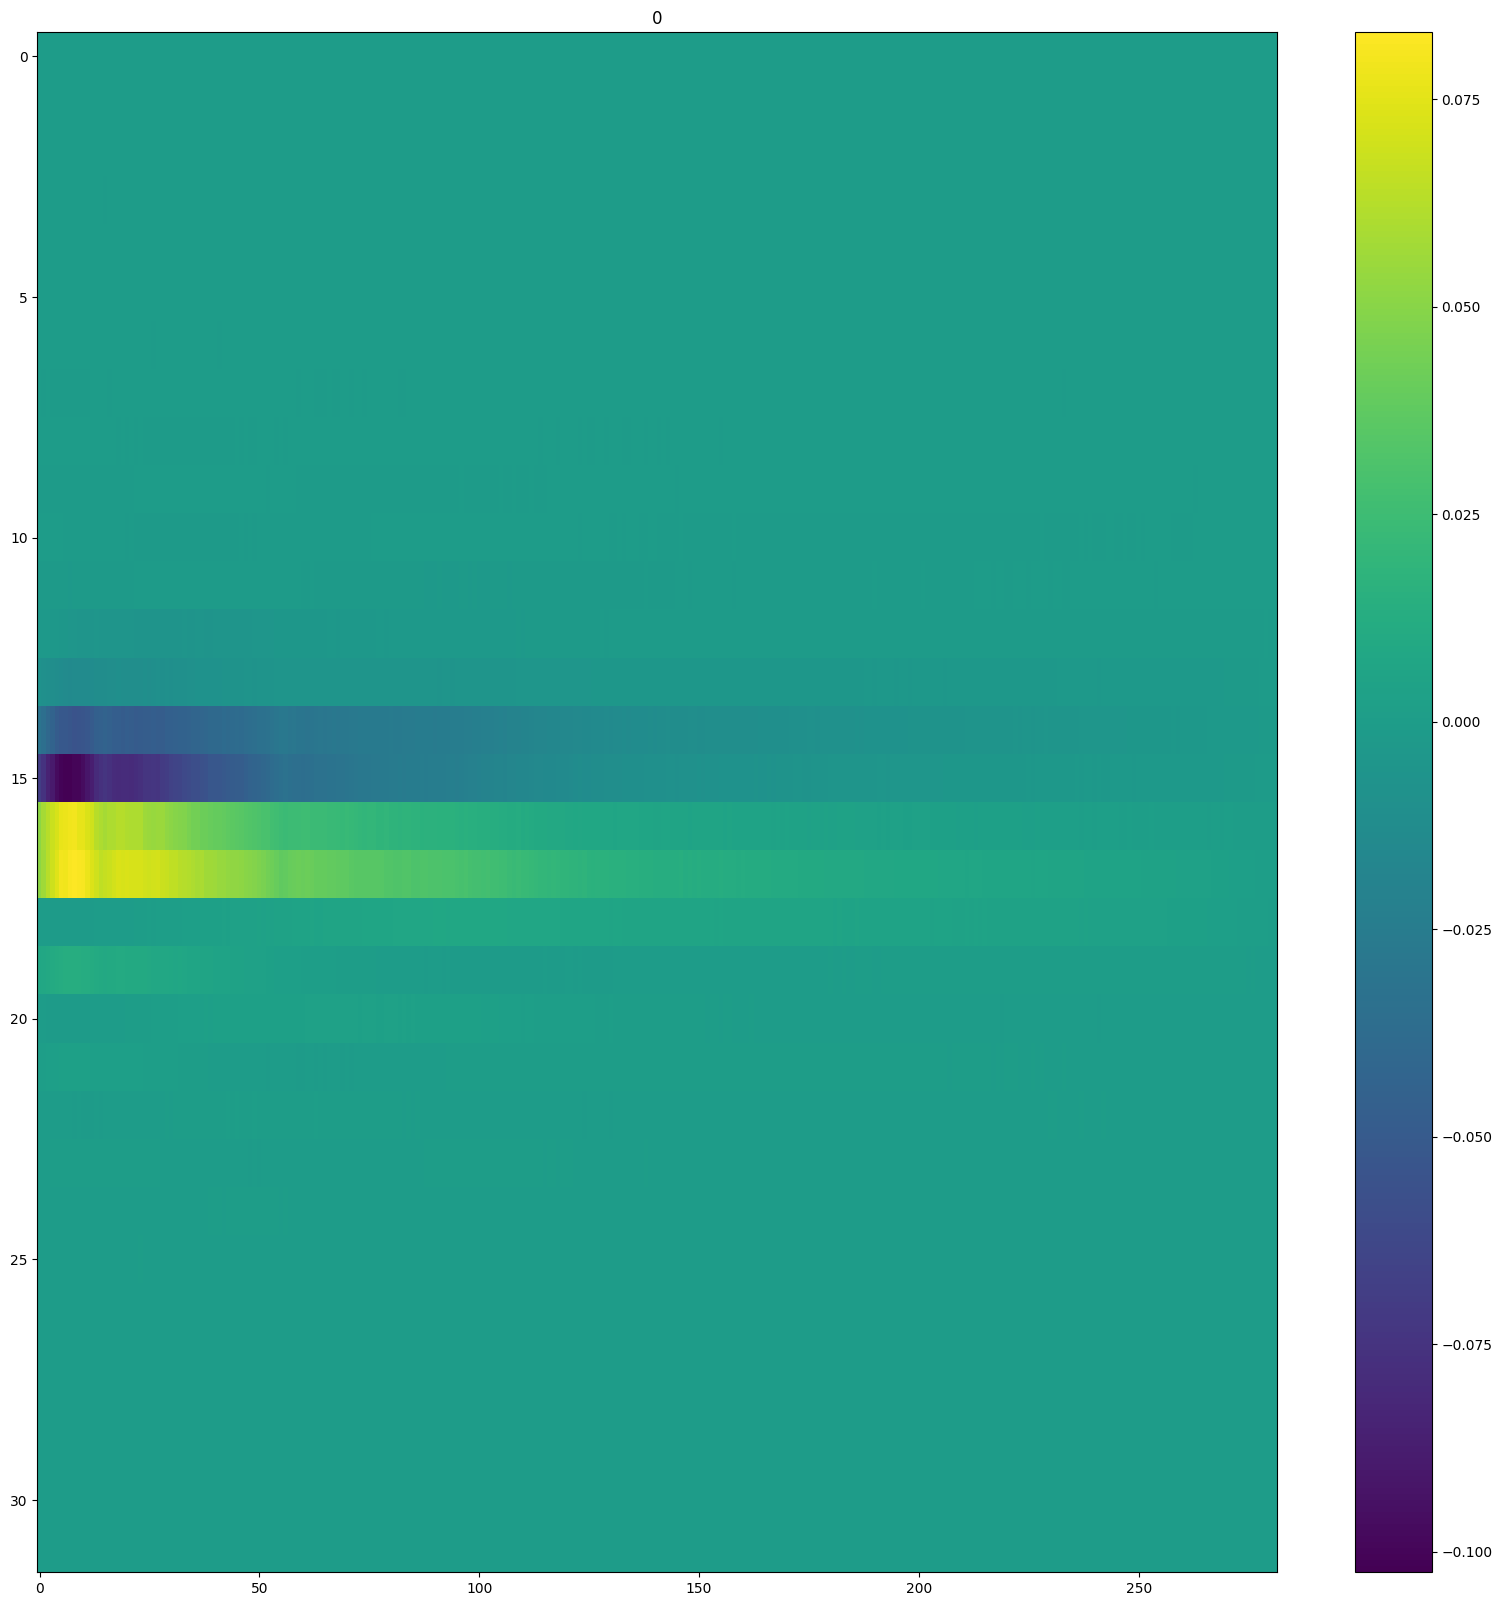

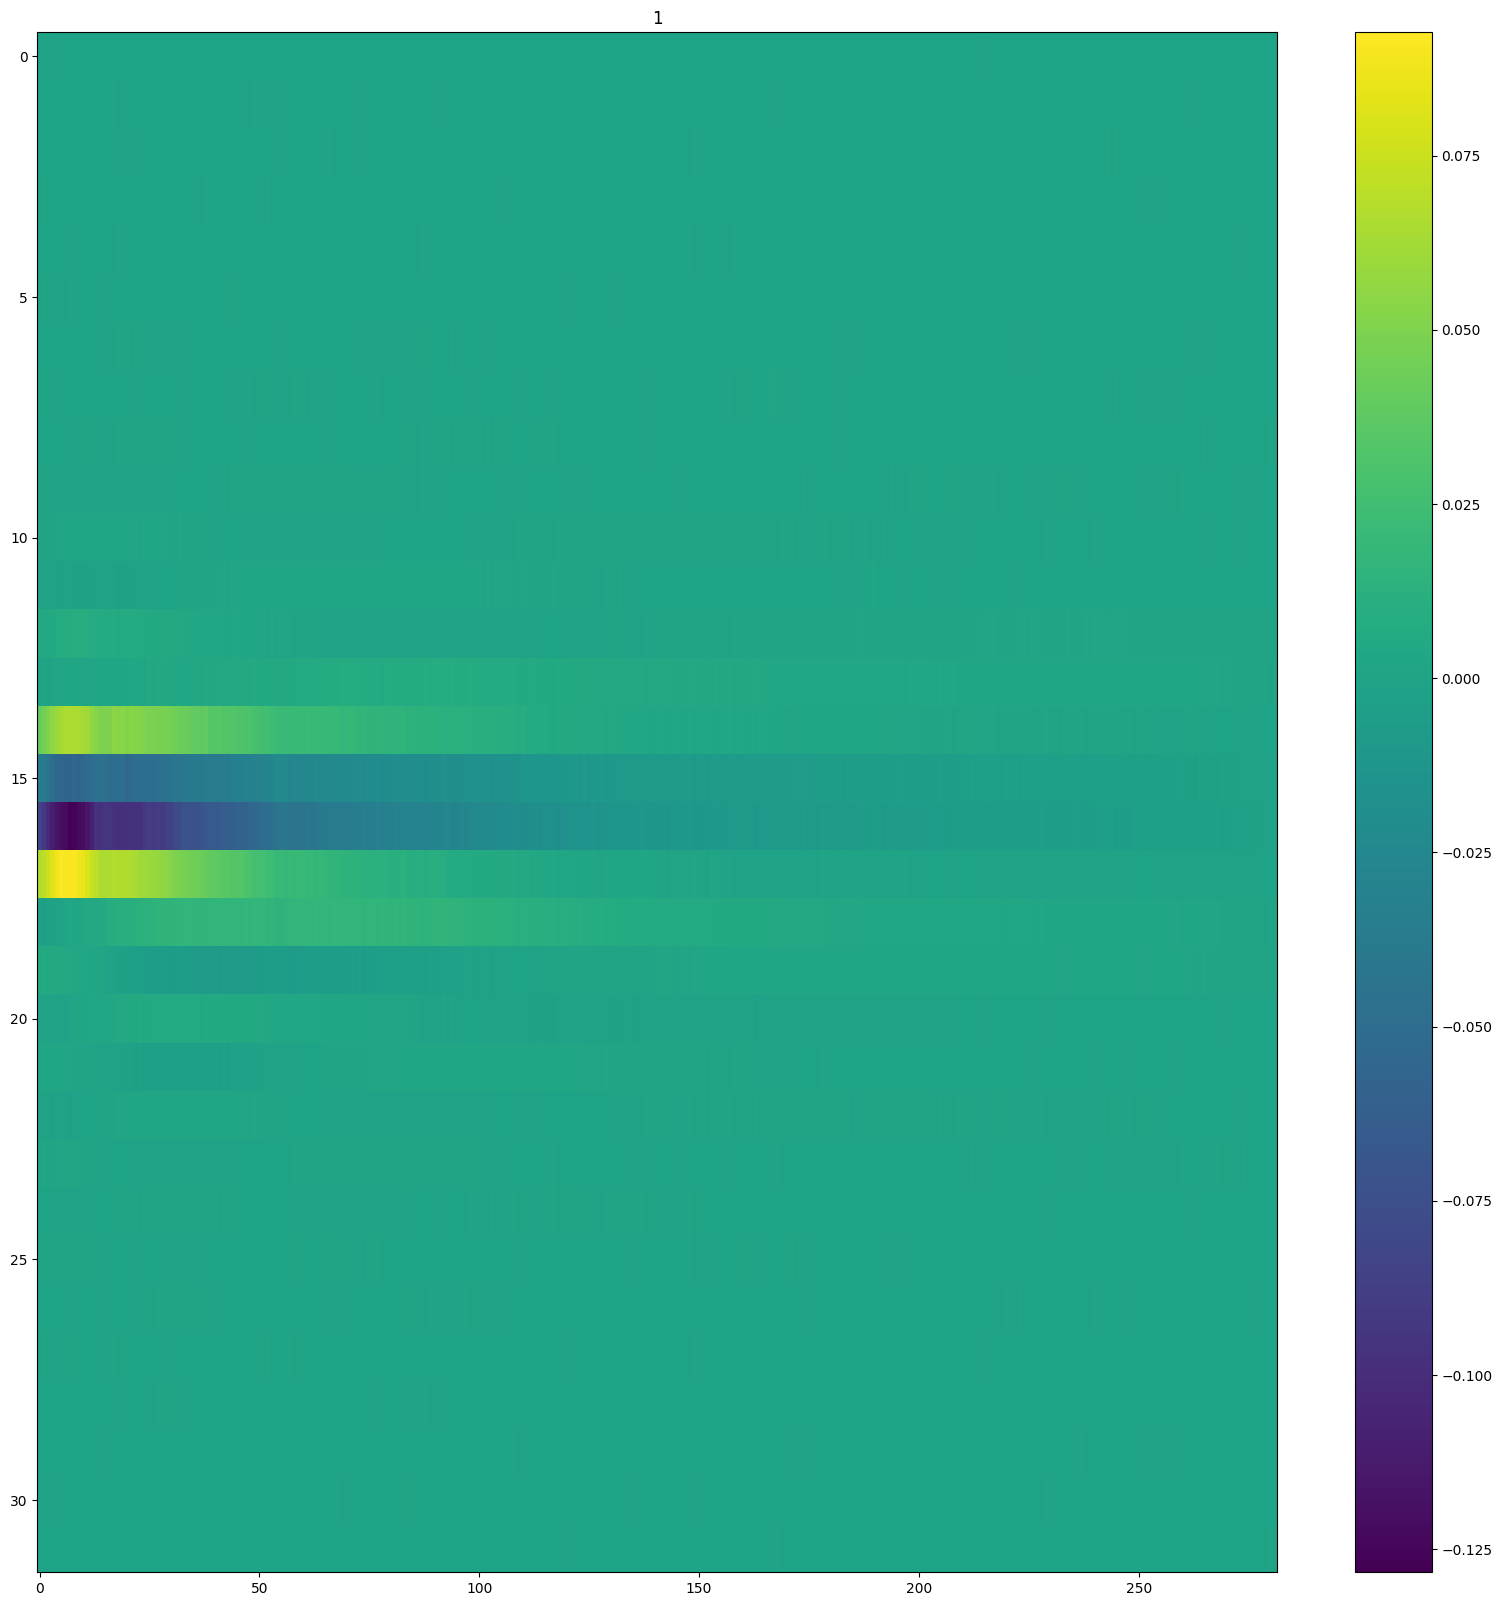

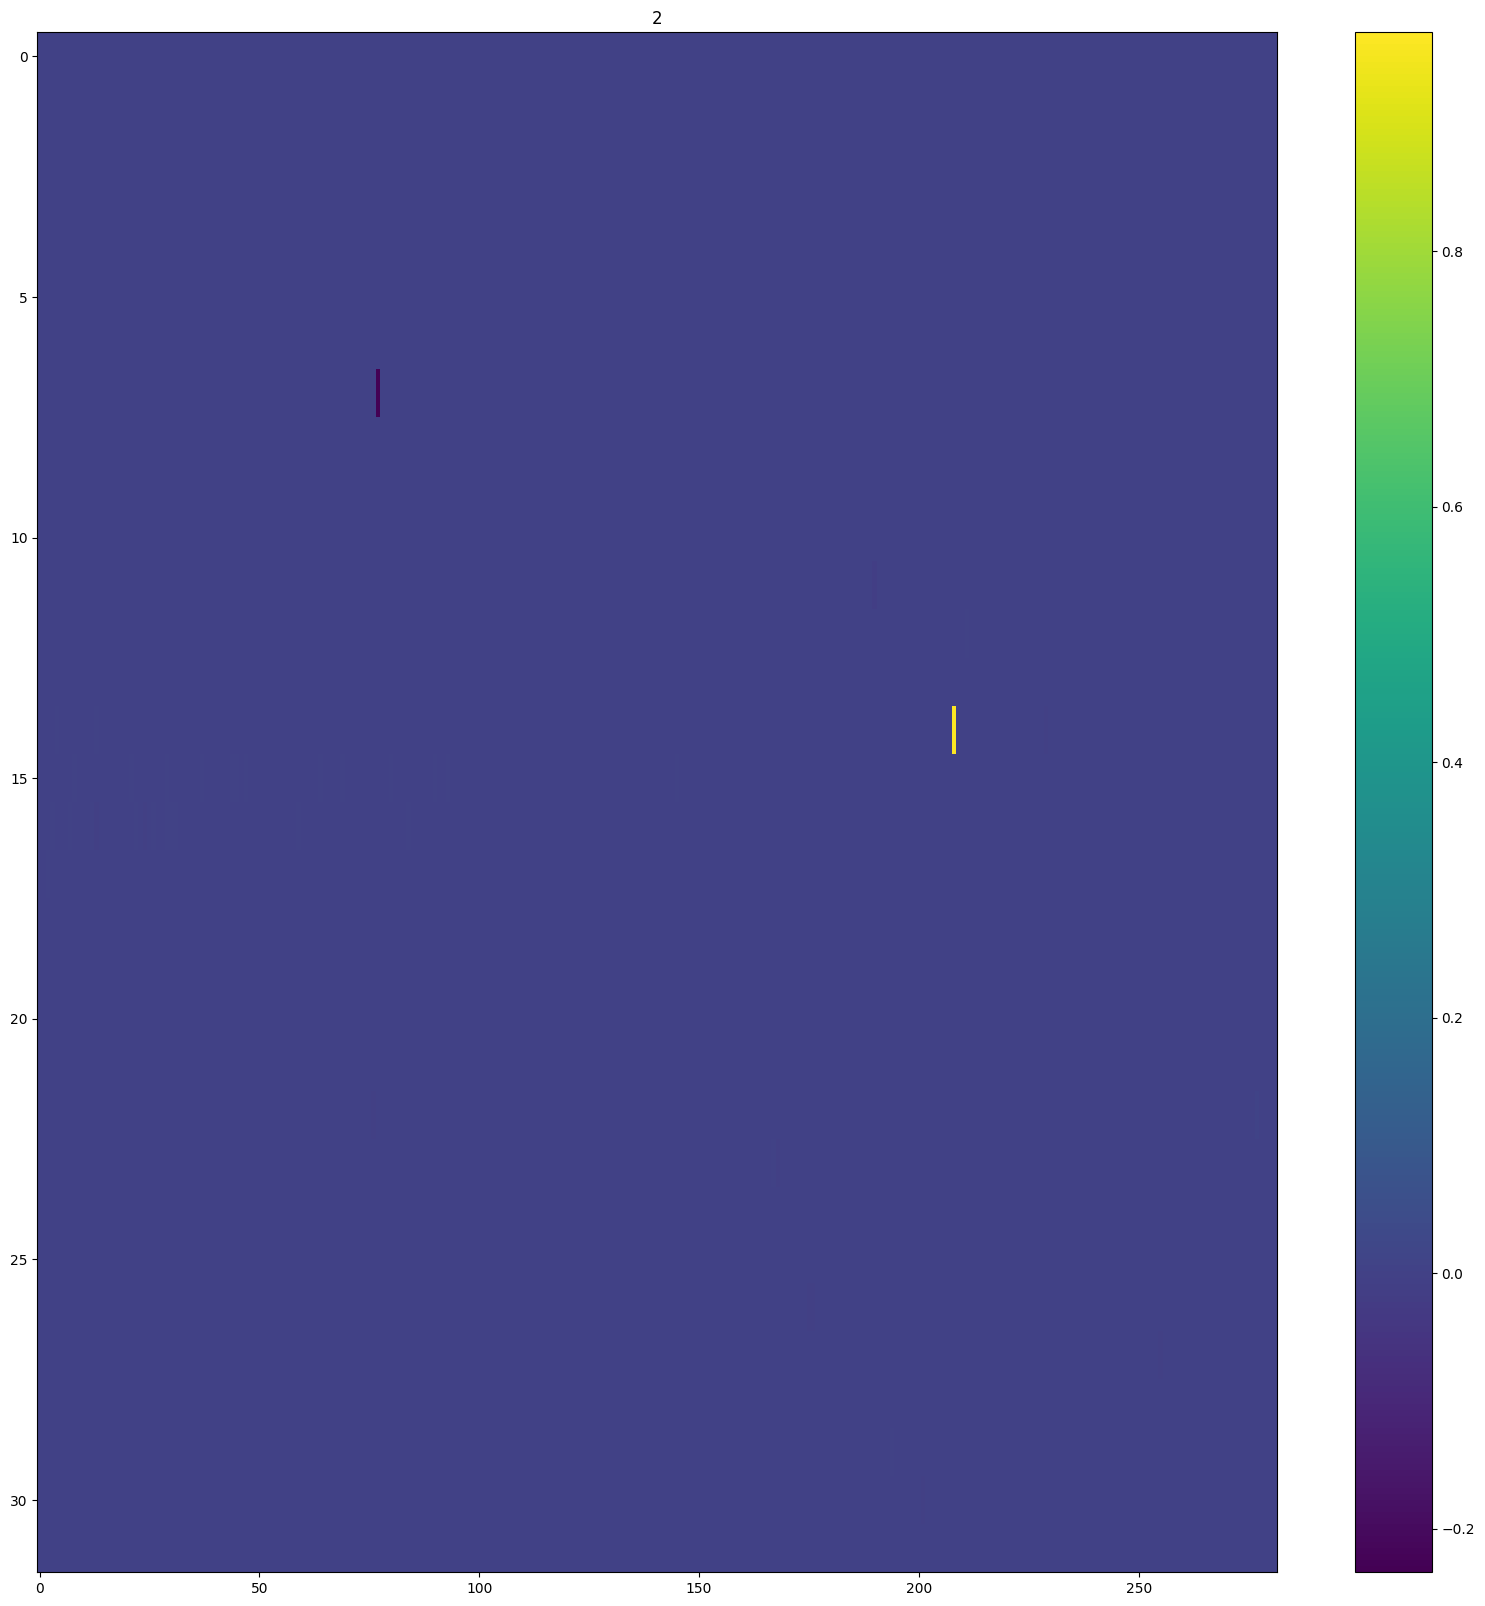

In [6]:
for ii in range(len(components)):
    plt.figure(figsize=(20,20))
    plt.imshow(components[ii].reshape(32,282).get(), aspect='auto', interpolation='none')
    plt.colorbar()
    plt.title(ii)

In [ ]:
plt.plot(weights[0].get())
plt.xlim([0,100])

In [ ]:
plt.plot(weights[1].get())
plt.xlim([0,100])

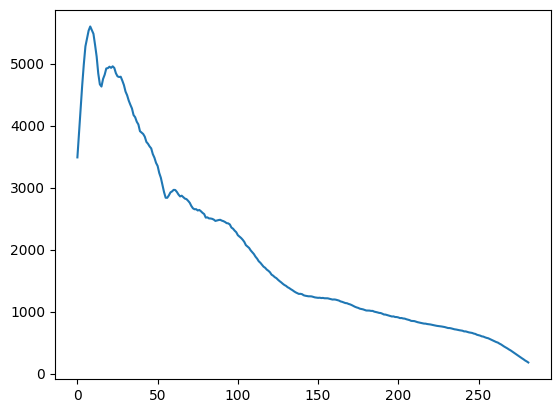

In [7]:
plt.plot(base_scaling.get())

In [ ]:
base_scaling